## What is Cointegration?

Unlike correlation, cointegration checks whether two non-stationary time series share a **stable long-term relationship**.

Two series *Xₜ* and *Yₜ* are cointegrated if there exists a coefficient **β** such that the spread:

**Zₜ = Yₜ − β·Xₜ** is **stationary** (*I(0)*): it has constant mean and variance, no trend, and it reverts to its mean.
And if X and Y are not stationnary

This property enables **pairs trading** — betting that the spread will return to equilibrium.


In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [5]:
tickers = ['XOM','CVX'] # ExxonMobil et chevron (compagnies pétrolière)

data = yf.download(tickers,start="2015-01-01",end="2024-12-31")['Close']
data= data.dropna()
data

C:\Users\maiss\AppData\Local\Temp\ipykernel_18212\217628892.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers,start="2015-01-01",end="2024-12-31")['Close']
[*********************100%***********************]  2 of 2 completed


Ticker,CVX,XOM
Date,,
2015-01-02,71.783989,58.967129
2015-01-05,68.914665,57.353683
2015-01-06,68.882812,57.048775
2015-01-07,68.825401,57.626846
2015-01-08,70.400337,58.586006
...,...,...
2024-12-23,139.700027,104.396103
2024-12-24,140.550125,104.494308
2024-12-26,140.686920,104.582695


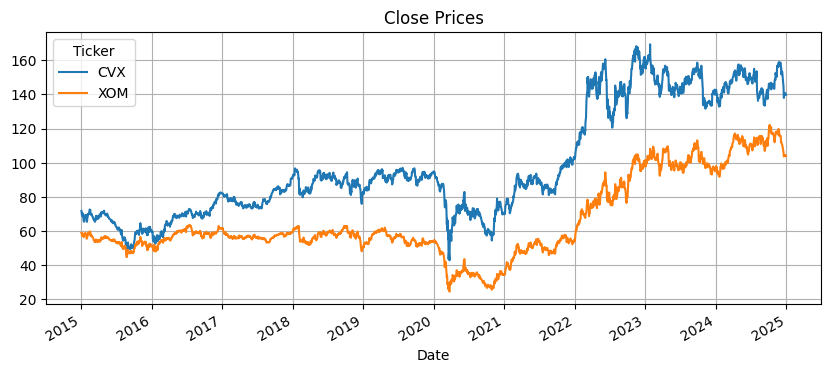

In [ ]:
data.plot(figsize=(10,4),title="Close Prices")
plt.grid(True)
plt.show()

Test that Zt is stationnary but Y and X not (necessary for cointegration) ; ADF test

##  What is a Unit Root?

A time series has a **unit root** if it follows a random walk and is **non-stationary**.

Consider an AR(1) process:

**yₜ = ρ·yₜ₋₁ + εₜ**

- If **|ρ| < 1** → the series is **stationary**
- If **ρ = 1** → the series has a **unit root** → it's a **random walk**

In that case:

**yₜ = yₜ₋₁ + εₜ**

The process **does not revert to a mean**, and shocks have **permanent effects**.  
This is why detecting a unit root (e.g. via the ADF test) is crucial for cointegration analysis.

The **Augmented Dickey-Fuller (ADF) test** checks for the presence of a **unit root**.

It runs a regression like: **Δyₜ = α + γ·yₜ₋₁ + ϕ₁·Δyₜ₋₁ + ... + ϕₚ·Δyₜ₋ₚ + εₜ**

and tests:

- **H₀**: γ = 0 → the series has a **unit root** (non-stationary)
- **H₁**: γ < 0 → the series is **stationary**

If the **p-value < 0.05**, we **reject H₀**:  
→ the series **does not have a unit root** → it is **stationary**.

This is key for cointegration:  
we test whether the residual spread **Zₜ = Yₜ − β·Xₜ** is stationary using ADF.


In [9]:
# we'll use ADF test to verify that series are individually not stationnary

for ticker in data.columns:
    result = adfuller(data[ticker])
    print(f"{ticker}ADF p-value: {result[1]:.4f}")

CVXADF p-value: 0.8071
XOMADF p-value: 0.8655


For both p value is high we accept H0 

##  Step 1: Understanding Cointegration

We want to determine if two non-stationary time series `Xₜ` and `Yₜ` share a stable long-term relationship.  
This happens if there exists a coefficient `β` such that the spread `Zₜ = Yₜ - β Xₜ` is **stationary** (i.e., `Zₜ ~ I(0)`).



###  How do we find β?

We use linear regression:

`Yₜ = β Xₜ + εₜ`  
Then: `Zₜ = εₜ = Yₜ - β Xₜ`

If the residuals `Zₜ` are stationary (tested via ADF), then `Xₜ` and `Yₜ` are **cointegrated**.


In [11]:
x = data['XOM']
y=data['CVX']
X = sm.add_constant(x) # addintercept

model = sm.OLS(y,X).fit()# regrssion linéaire

Z = model.resid

In [ ]:
# Test if Z is stationnary
adf_result =adfuller(Z)

print(f"p-value: {adf_result[1]}")

p-value: 0.20163291740712908


In [16]:
import numpy as np
x = np.log(data['XOM'])
y = np.log(data['CVX'])

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
z = model.resid

from statsmodels.tsa.stattools import adfuller
print(adfuller(z)[1])  # nouvelle p-value


0.32933994677850076


The p_value is too high we can continue with this 2 series 

In [ ]:
from itertools import combinations

# Let's take several ticker and practice ADF to see if there are 2 cointegrated series 

tickers = ['CVX', 'XOM', 'BP', 'TTE', 'SHEL']  # gas company 


data = yf.download(tickers, start="2015-01-01", end="2024-12-31")['Close']


data = data.dropna() 
log_prices = np.log(data)

results = []

# test Z for severals pairs of stocks 
for t1, t2 in combinations(log_prices.columns, 2):
    y = log_prices[t1]
    x = log_prices[t2]
    x_ = sm.add_constant(x)
    model = sm.OLS(y, x_).fit()
    beta = model.params[1]
    residuals = model.resid
    pval = adfuller(residuals)[1]
    
    results.append({'pair': (t1, t2), 'beta': beta, 'p-value': pval})

# Résultats triés par p-value
result_df = pd.DataFrame(results).sort_values('p-value')
print(result_df)


C:\Users\maiss\AppData\Local\Temp\ipykernel_18212\4069581676.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  5 of 5 completed
C:\Users\maiss\AppData\Local\Temp\ipykernel_18212\4069581676.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\maiss\AppData\Local\Temp\ipykernel_18212\4069581676.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\maiss\AppData\Local\Temp\ipykernel_18212\406958167

          pair      beta   p-value
5   (CVX, TTE)  1.059924  0.006046
1   (BP, SHEL)  0.811338  0.012818
7  (SHEL, TTE)  0.868241  0.128817
0    (BP, CVX)  0.574813  0.183536
9   (TTE, XOM)  0.712696  0.185481
4  (CVX, SHEL)  1.011162  0.207973
2    (BP, TTE)  0.685486  0.222959
3    (BP, XOM)  0.535169  0.223421
8  (SHEL, XOM)  0.682513  0.319213
6   (CVX, XOM)  0.806814  0.329340


From the result we can see that Total and Chevron represent a cointegration let's continue with theses 2 assets to continue 

In [21]:
import numpy as np
x = np.log(data['TTE'])
y = np.log(data['CVX'])

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
Z = model.resid

print(adfuller(Z)[1])  

0.006045894338695538


P value < 0.05 H0 is rejected Z is stationnary we have found our good candidates

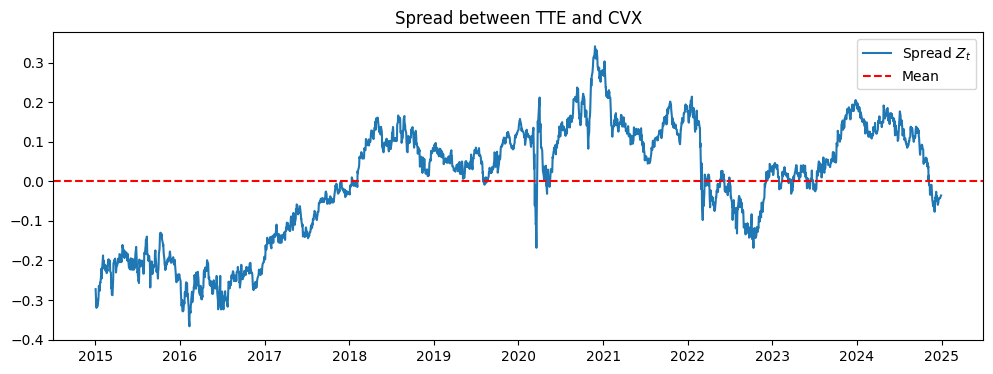

In [ ]:
# Let's make sure there is a mean reversion occurs 

plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Spread $Z_t$')
plt.axhline(residuals.mean(), color='red', linestyle='--', label='Mean')
plt.title('Spread between TTE and CVX')
plt.legend()
plt.show()
